In [239]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, QuantileRegressor
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import statsmodels.api as sm

# 1a. OLS vs. OAV

Recall the derivation of the OLS estimates $\hat{\beta}_0, \hat{\beta}_1$. Let $f$ be SSE such that we seek
$$\argmin_{\hat{\beta}_0, \hat{\beta}_1} f = \argmin_{\hat{\beta}_0, \hat{\beta}_1} \sum_{i=1}^n (y_i - \hat{\beta}_0 - \hat{\beta}_1x_i)^2$$
Take partial derivatives and set them to $0$.
$$\begin{align*}
    \frac{\partial f}{\partial \hat{\beta}_0} = -2 * \sum_{i=1}^n (y_i - \hat{\beta}_0 - \hat{\beta}_1x_i) = 0 && 
    \frac{\partial f}{\partial \hat{\beta}_1} = -2 * \sum_{i=1}^n x_i(y_i - \hat{\beta_0} - \hat{\beta}_1x_i) = 0\\
    n\hat{\beta}_0 = \sum_{i=1}^n (y_i - \hat{\beta}_1x_i) &&
     \sum_{i=1}^n x_i(y_i - \hat{\beta}_0) = \sum_{i=1}^n x_i(\hat{\beta}_1 x_i) \\
     \hat{\beta}_0 = \bar{y} - \hat{\beta}_1\bar{x} && \hat{\beta}_1 = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^n (x_i - \bar{x})^2}
\end{align*}$$

Let $g$ be OAV (also sometimes known as Least Absolute Deviation (LAD)). We see that 
$$\argmin_{\hat{\beta}_0, \hat{\beta}_1} g = \argmin_{\hat{\beta}_0, \hat{\beta}_1} \sum_{i=1}^n |y_i - \hat{\beta}_0 - \hat{\beta}_1x_i|$$
But observe that $|x|$ is not differentiable at all points. Thus, we have to solve for these estimates another way, most commonly linear programming. Here, I will use statsmodels' quantile regression, where $q=0.5$ is a special case that minimizes OAV/LAD.


In [240]:
# Load the data and change percentages to actual returns.
ind_df = pd.read_csv("ind30_m_vw_rets.csv").rename(columns={"Unnamed: 0": "Date"}) / 100
mgr_df = pd.read_csv("mgr_r.csv").rename(columns={"Unnamed: 0": "Date"})
X = ind_df["Beer "].values.reshape(-1, 1)
y = np.ravel(mgr_df["mgr_r"])

# Using sklearn Quantile regression (q=0.5) to find OAV/LAD estimates.
model = QuantileRegressor(quantile=0.5)
model.fit(X, y)
beta_0_oav = model.intercept_
beta_1_oav = model.coef_[0]
print(f"OAV: beta_0={beta_0_oav}, beta_1={beta_1_oav}")

# Using sklearn linear regression to find OLS Estimates.
model = LinearRegression()
model.fit(X, y)
beta_0_ols = model.intercept_
beta_1_ols = model.coef_[0]
print(f"OLS: beta_0={beta_0_ols}, beta_1={beta_1_ols}")

/Users/jameszhang/miniconda3/envs/bufn/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(


OAV: beta_0=0.010194547801237741, beta_1=-7.051670256764782e-14
OLS: beta_0=0.0036695517356989185, beta_1=0.4845264343755612


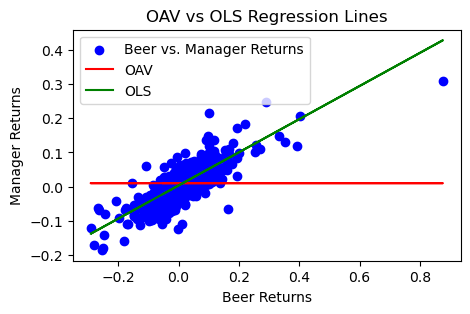

In [241]:
plt.figure(figsize=(5, 3))
plt.scatter(X, y, color='blue', label='Beer vs. Manager Returns')
oav_y_pred = beta_0_oav + beta_1_oav * X
plt.plot(X, oav_y_pred, color='red', label='OAV')
ols_y_pred = beta_0_ols + beta_1_ols * X
plt.plot(X, ols_y_pred, color='green', label='OLS')
plt.title('OAV vs OLS Regression Lines')
plt.xlabel('Beer Returns')
plt.ylabel('Manager Returns')
plt.legend()
plt.show()

# 1b. Bootstrapping


In [242]:
bootstrap_df = pd.DataFrame({
    "Beer": ind_df["Beer "],
    "mgr_r": mgr_df["mgr_r"]
})

# Bootstrapping to find OAV Estimates.
N = 10000
M = len(bootstrap_df)
beta_0_bootstrap, beta_1_bootstrap = [], []
for i in range(N):
    # Generate a sample WITH replacement.
    sample = bootstrap_df.sample(n=M, replace=True)
    X = sample["Beer"].values.reshape(-1, 1)
    y = np.ravel(sample["mgr_r"])
    model = LinearRegression()
    model.fit(X, y)
    beta_0_bootstrap.append(model.intercept_)
    beta_1_bootstrap.append(model.coef_[0])

beta_1_mean = np.mean(beta_1_bootstrap)
beta_1_std = np.std(beta_1_bootstrap)
z_95 = 1.96
lb = beta_1_mean - z_95 * (beta_1_std / np.sqrt(N))
ub = beta_1_mean + z_95 * (beta_1_std / np.sqrt(N))
lb, ub

(0.48623775137782427, 0.48713643257417977)

The 95% confidence interval for $\hat{\beta}_1$ is $$[0.486642, 0.487542]$$

# 1c. Constrained Optimization

Without the constraints, we could find $\beta$ to be the OLS solution 
$$\beta = (X^T X)^{-1}X^T y$$
However, given these constraints, we have to revert to scipy.optimize and define these constraints ourselves.

In [243]:
X_df = ind_df.drop(columns="Date")
X = X_df.values
y = np.ravel(mgr_df["mgr_r"])

def objective(beta, X, y):
    return np.sum((X @ beta - y) ** 2)

sum_to_one_constraint = {'type': 'eq', 'fun': lambda beta: np.sum(beta) - 1}
N = X.shape[1]
beta_initial = np.zeros(N)
# Bounds constraint enforces all weights to be between 0 and 1.
result = minimize(objective, beta_initial, args=(X, y), bounds=[(0, 1)] * N, constraints=sum_to_one_constraint)
beta_ols_constrained = result.x

industries = list(ind_df.columns)
ind_to_weight = {industries[i]: beta_ols_constrained[i] for i in range(N)}
# Sort the dictionary by highest weights.
sorted_ind_to_weight = dict(sorted(ind_to_weight.items(), key=lambda x: x[1], reverse=True))

# Get the top 5 weighted industries and their respective weights.
top_ind = list(sorted_ind_to_weight.keys())
weights = list(sorted_ind_to_weight.values())
for i in range(5):
    print(f"{top_ind[i]}: {weights[i]}")

Beer : 0.5204844482723713
Food : 0.27809288264081156
Util : 0.0912756631538518
Date: 0.06659267263257714
Coal : 0.020338016926439814


# 2.1a and 2.1b. Assigning EDF Portfolio Indices

In [244]:
edf_df = pd.read_csv("edf_month_1990_2019.csv").drop(columns=["Unnamed: 0"])
edf_df = edf_df.sort_values(["curdat", "permno"])
# Find the 10 breakpoints from the CDF and assign portfolio indicies. (Taken from size_replication notebook)
edf_df['edf_port']= 1 + edf_df.groupby('curdat')['edf'].transform(lambda x: pd.qcut(x, 10, labels=False))
edf_df.head(10)

,permno,curdat,retx,edf,edf_port
0,10001,199001,-0.018519,2.980550e-05,5
407,10005,199001,0.000000,1.973512e-02,7
423,10010,199001,-0.162791,3.574195e-02,7
483,10011,199001,0.561644,2.431453e-07,4
579,10012,199001,-0.230769,4.127780e-01,9
751,10016,199001,0.061538,6.294080e-01,9
875,10018,199001,0.555556,1.567700e-05,4
938,10019,199001,-0.127273,1.507933e-22,1
1057,10021,199001,0.107143,5.667942e-01,9
1107,10024,199001,0.033333,1.732816e-01,8


# 2.2. Sample Statistics

In [245]:
port_to_monthly_returns = {}
for port in range(1, 11):
    df = edf_df[edf_df["edf_port"] == port]
    means = df.groupby("curdat")["retx"].mean().values
    port_to_monthly_returns[str(port)] = means

# Create the dataframe shown in the HW3_tutorial slideshow.
port_ret_df = pd.DataFrame(port_to_monthly_returns, index=edf_df["curdat"].unique())
port_ret_df = port_ret_df.rename_axis("curdat")
port_ret_df = port_ret_df.rename_axis("edf_port", axis=1)

# Load the FF3 data and get only the dates shared with the ind_df. 
ff3_df = pd.read_csv("F-F_Research_Data_Factors_monthly.csv")
dates = set(ff3_df["mon"].unique())
sliced_ff3_df = ff3_df[ff3_df["mon"].isin(set(port_ret_df.index.unique()))]
sliced_ff3_df = sliced_ff3_df.set_index("mon")
# Get returns and not percentages.
sliced_ff3_df /= 100
port_ret_df = port_ret_df[port_ret_df.index.isin(dates)]
port_ret_df

edf_port,1,2,3,4,5,6,7,8,9,10
curdat,,,,,,,,,,
199001,-0.071882,-0.063992,-0.068018,-0.051137,-0.058680,-0.068747,-0.054324,-0.043685,-0.040020,-0.040388
199002,0.017969,0.029681,0.016206,0.029345,0.022992,0.020108,0.006041,0.020147,0.003011,0.009783
199003,0.040453,0.053970,0.043579,0.030298,0.043341,0.038824,0.041638,0.022323,0.033330,0.015609
199004,-0.027157,-0.030853,-0.030442,-0.018969,-0.028502,-0.031579,-0.040148,-0.043685,-0.015234,-0.019144
199005,0.090579,0.073790,0.067727,0.058988,0.039807,0.069111,0.053870,0.032415,0.023465,0.031303
...,...,...,...,...,...,...,...,...,...,...
201808,0.026795,0.026750,0.035084,0.029055,0.028832,0.036536,0.015393,0.017523,0.014609,-0.012484
201809,-0.003578,0.004740,-0.001456,-0.014152,-0.006904,0.011755,-0.004069,-0.020193,-0.029168,-0.042230
201810,-0.083670,-0.098409,-0.097326,-0.102713,-0.095460,-0.095983,-0.097991,-0.099281,-0.106857,-0.105269


In [246]:
port_to_stats = {}
for port in range(1, 11):
    port_to_stats[str(port)] = [
        port_ret_df[str(port)].mean(), 
        port_ret_df[str(port)].std(),
        np.corrcoef(port_ret_df[str(port)], sliced_ff3_df["Mkt-RF"])[0][1]
    ]

port_stats_df = pd.DataFrame(port_to_stats, index=["Mean", "Standard Deviation", "Correlation with Mkt-RF"])
port_stats_df = port_stats_df.rename_axis("stats")
port_stats_df = port_stats_df.rename_axis("edf_port", axis=1)
port_stats_df

edf_port,1,2,3,4,5,6,7,8,9,10
stats,,,,,,,,,,
Mean,0.015288,0.014524,0.013889,0.012698,0.011217,0.009083,0.007232,0.004470,0.002158,-0.002831
Standard Deviation,0.043966,0.046658,0.048743,0.050230,0.053290,0.055126,0.058412,0.062674,0.068574,0.078469
Correlation with Mkt-RF,0.854871,0.855831,0.854381,0.855357,0.841420,0.847054,0.824775,0.801042,0.757435,0.702135


# 2.3a. Calculating CAPM Alphas, Betas, and P-Values

In [247]:
port_to_alpha_beta = {}
excess_port_rets_df = pd.DataFrame(port_ret_df - sliced_ff3_df["RF"].values.reshape(-1, 1))
for port in range(1, 11):
    X = sliced_ff3_df["Mkt-RF"].values.reshape(-1, 1)
    X = sm.add_constant(X)
    y = np.ravel(excess_port_rets_df[str(port)])
    model = sm.OLS(y, X)
    results = model.fit()
    alpha, beta = results.params
    alpha_pvalue, beta_pvalue = results.pvalues
    port_to_alpha_beta[str(port)] = [alpha, beta, alpha_pvalue, beta_pvalue]

capm_df = pd.DataFrame(port_to_alpha_beta, index=["Alpha", "Beta", "Alpha Pvalue", "Beta Pvalue"])
capm_df = capm_df.rename_axis("edf_port", axis=1)
capm_df = capm_df.rename_axis("values")
capm_df

edf_port,1,2,3,4,5,6,7,8,9,10
values,,,,,,,,,,
Alpha,7.535496e-03,6.428660e-03,5.543607e-03,4.159902e-03,2.405885e-03,6.309521e-07,-2.067238e-03,-5.124984e-03,-7.691025e-03,-1.313996e-02
Beta,8.888394e-01,9.442128e-01,9.846423e-01,1.015792e+00,1.060015e+00,1.103813e+00,1.138790e+00,1.186626e+00,1.227594e+00,1.302068e+00
Alpha Pvalue,2.262560e-09,1.171648e-06,6.365022e-05,3.415502e-03,1.248589e-01,9.996845e-01,2.506514e-01,1.257739e-02,1.749769e-03,1.972878e-05
Beta Pvalue,8.743097e-102,3.602068e-102,5.382503e-101,4.084669e-101,1.363866e-94,7.700187e-97,1.359158e-87,6.617713e-79,7.647462e-66,5.744905e-53


# 2.3b. Plotting Alphas, Betas, Mean Returns

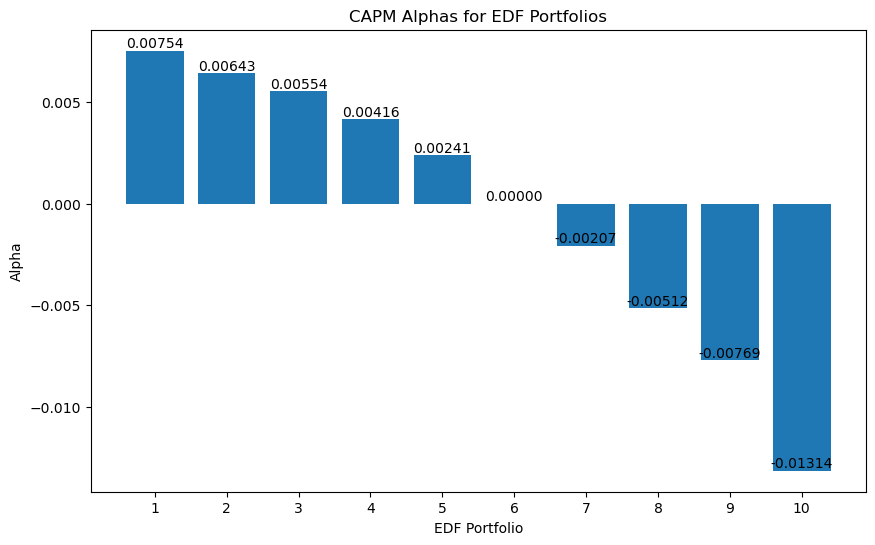

In [248]:
# Extracting the alpha values for each EDF portfolio
alphas = [capm_df[str(port)]["Alpha"] for port in range(1, 11)]

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), alphas)
for i, alpha in enumerate(alphas):
    plt.text(i + 1, alpha, f'{alpha:.5f}', ha='center', va='bottom')
    
plt.xticks(range(1, 11))
plt.xlabel('EDF Portfolio')
plt.ylabel('Alpha')
plt.title('CAPM Alphas for EDF Portfolios')
plt.show()

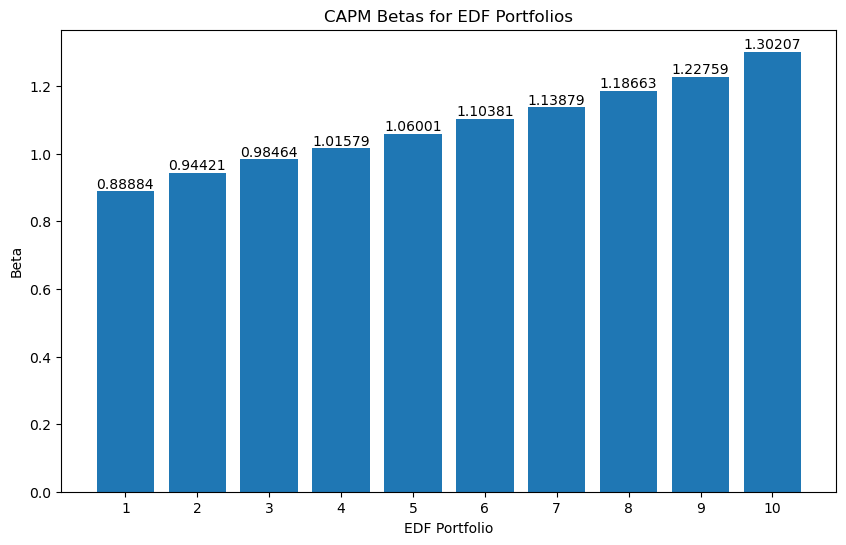

In [249]:
# Extracting the betas for each EDF portfolio
betas = [capm_df[str(port)]["Beta"] for port in range(1, 11)]

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), betas)
for i, beta in enumerate(betas):
    plt.text(i + 1, beta, f'{beta:.5f}', ha='center', va='bottom')
    
plt.xticks(range(1, 11))
plt.xlabel('EDF Portfolio')
plt.ylabel('Beta')
plt.title('CAPM Betas for EDF Portfolios')
plt.show()

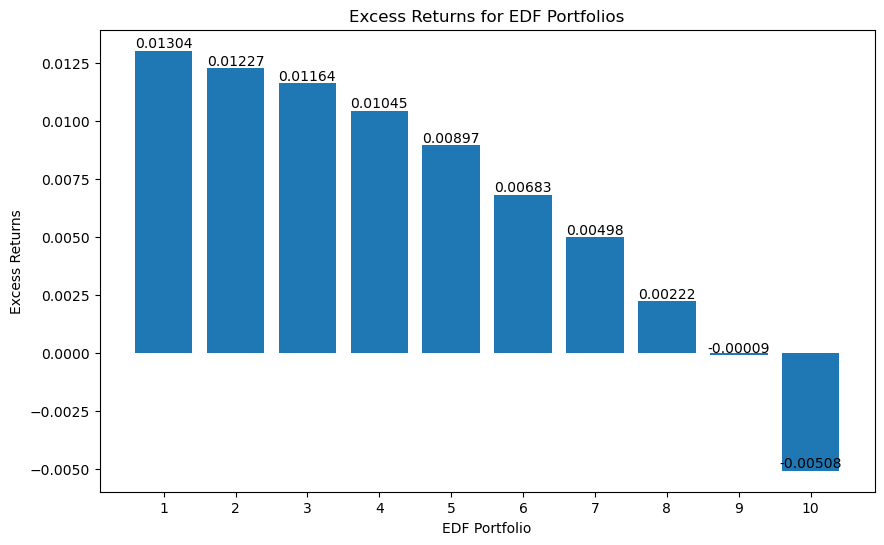

In [250]:
excess_rets = [excess_port_rets_df[str(port)].mean() for port in range(1, 11)]

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), excess_rets)
for i, x in enumerate(excess_rets):
    plt.text(i + 1, x, f'{x:.5f}', ha='center', va='bottom')
    
plt.xticks(range(1, 11))
plt.xlabel('EDF Portfolio')
plt.ylabel('Excess Returns')
plt.title('Excess Returns for EDF Portfolios')
plt.show()

# 2.3c. Returns Implied by the CAPM

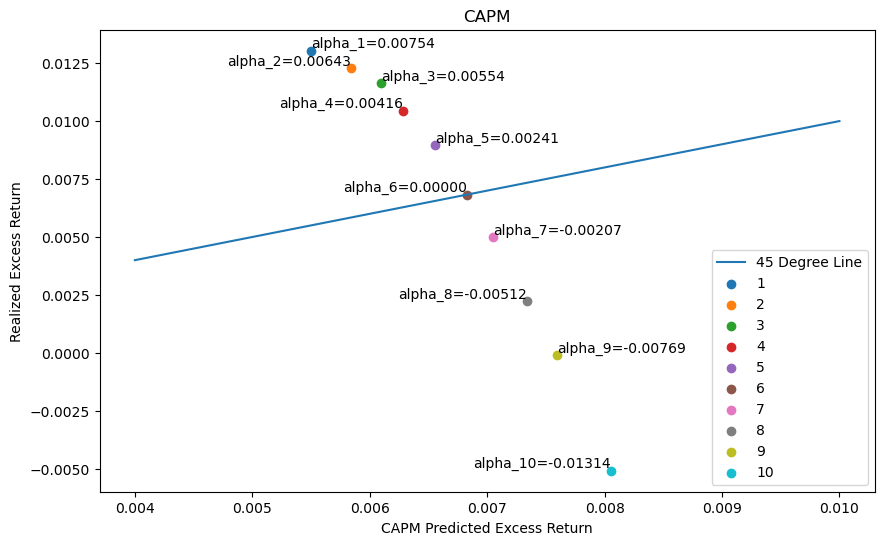

In [251]:
plt.figure(figsize=(10, 6))
x = np.linspace(0.004, 0.01, 100)
plt.plot(x, x, label="45 Degree Line")
mkt_rets = sliced_ff3_df["Mkt-RF"].mean()
for port in range(1, 11):
    alpha = capm_df[str(port)]["Alpha"]
    beta = capm_df[str(port)]["Beta"]
    capm_pred = beta * mkt_rets
    realized_rets = excess_port_rets_df[str(port)].mean()
    plt.scatter(capm_pred, realized_rets, label=str(port))
    h = 'left' if port % 2 else 'right'
    plt.text(capm_pred, realized_rets, f"alpha_{str(port)}={alpha:.5f}", va='bottom', ha=h)

plt.legend()
plt.xlabel("CAPM Predicted Excess Return")
plt.ylabel("Realized Excess Return")
plt.title("CAPM")
plt.show()

# 2.3d. Discussing Results

First and foremost, we see that the empirical results drastically contradict the theory proposed by the CAPM because all portfolios earn a positive or negative alpha aside from Portfolio 6. While error bars are not plotted, if the CAPM were true, all portfolios would fall on the blue SML, which is clearly not the case. This is the first anomaly.

It is typically assumed throughout finance and economics that high exposure should yield higher expected returns. Intuitively, a trader who is more willing to take on high risks should earn high rewards. The CAPM, which assumes that all traders are rational mean-variance optimizers, is in support of this theory, and yet this is where we observe the second anomaly. Portfolios with high betas and thus higher risks/exposures clearly earn lower average excess returns.


# 2.4a. FF3 Alphas, Coefficients, and P-Values

In [252]:
port_to_ff3 = {}
for port in range(1, 11):
    X = sliced_ff3_df[["Mkt-RF", "SMB", "HML"]].values.reshape(-1, 3)
    X = sm.add_constant(X)
    y = np.ravel(excess_port_rets_df[str(port)])
    model = sm.OLS(y, X)
    results = model.fit()
    alpha, beta_m, beta_smb, beta_hml = results.params
    alpha_p, beta_m_p, beta_smb_p, beta_hml_p = results.pvalues
    port_to_ff3[str(port)] = [alpha, beta_m, beta_smb, beta_hml, alpha_p, beta_m_p, beta_smb_p, beta_hml_p]

port_ff3_df = pd.DataFrame(port_to_ff3, 
                           index=["Alpha", "Market Beta", "SMB Beta", "HML Beta", 
                                  "Alpha Pvalue", "Market Beta PValue", "SMB Beta Pvalue", "HML Beta Pvalue"])
port_ff3_df = port_ff3_df.rename_axis("values")
port_ff3_df = port_ff3_df.rename_axis("edf_port", axis=1)
port_ff3_df

edf_port,1,2,3,4,5,6,7,8,9,10
values,,,,,,,,,,
Alpha,7.401998e-03,6.128437e-03,5.092335e-03,3.524591e-03,1.787843e-03,-6.724367e-04,-2.872350e-03,-5.955375e-03,-8.628840e-03,-1.429929e-02
Market Beta,8.075420e-01,8.571838e-01,8.858634e-01,9.181635e-01,9.430834e-01,9.996565e-01,1.032276e+00,1.075358e+00,1.110500e+00,1.187823e+00
SMB Beta,5.037970e-01,5.825437e-01,6.915630e-01,7.355265e-01,8.416880e-01,7.834096e-01,8.332351e-01,8.674994e-01,9.304926e-01,9.749912e-01
HML Beta,5.083961e-02,1.162964e-01,1.754648e-01,2.478729e-01,2.406849e-01,2.625892e-01,3.144754e-01,3.243201e-01,3.664518e-01,4.536330e-01
Alpha Pvalue,6.518167e-15,2.532767e-11,2.196957e-10,2.702900e-06,1.742366e-02,4.807217e-01,1.453602e-02,6.487422e-05,8.486561e-06,6.109321e-08
Market Beta PValue,1.066281e-121,1.650949e-131,2.232914e-152,6.256704e-164,9.397282e-166,5.433452e-142,9.867534e-121,4.183821e-99,5.203009e-76,6.992361e-56
SMB Beta Pvalue,3.002171e-47,1.245002e-59,2.036020e-87,1.892909e-99,3.837429e-113,9.712735e-80,1.419383e-66,2.011665e-51,5.298639e-39,3.366584e-26
HML Beta Pvalue,1.091554e-01,2.050164e-04,3.519078e-10,1.463990e-19,3.021456e-18,3.724661e-14,1.371422e-13,8.396826e-10,7.261162e-08,7.682592e-07


# 2.4b. Plotting FF3 Alphas, Loadings, Mean Returns

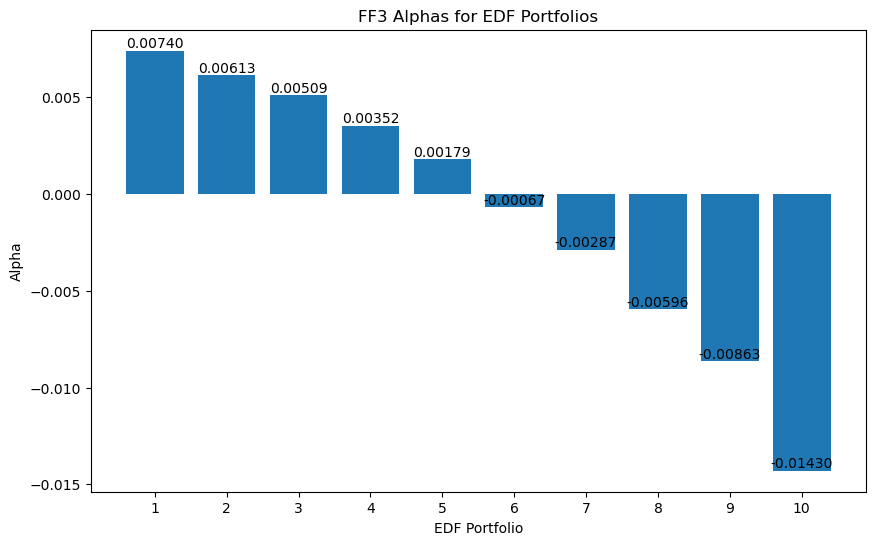

In [253]:
# Extracting the alpha values for each EDF portfolio
alphas = [port_ff3_df[str(port)]["Alpha"] for port in range(1, 11)]

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), alphas)
for i, alpha in enumerate(alphas):
    plt.text(i + 1, alpha, f'{alpha:.5f}', ha='center', va='bottom')
    
plt.xticks(range(1, 11))
plt.xlabel('EDF Portfolio')
plt.ylabel('Alpha')
plt.title('FF3 Alphas for EDF Portfolios')
plt.show()

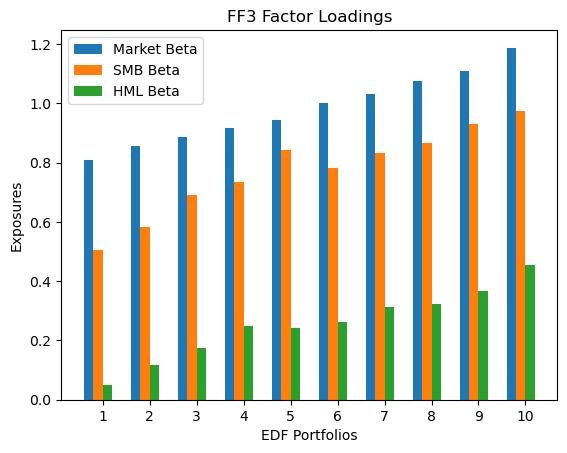

In [254]:
edf_portfolios = range(1, 11)
factors = ['Market Beta', 'SMB Beta', 'HML Beta']
data = {
    'Market Beta': [port_ff3_df[str(port)]["Market Beta"] for port in range(1, 11)], 
    'SMB Beta': [port_ff3_df[str(port)]["SMB Beta"] for port in range(1, 11)], 
    'HML Beta': [port_ff3_df[str(port)]["HML Beta"] for port in range(1, 11)], 
}

# Plotting the bar chart with sub bars.
bar_width = 0.2
x = np.arange(len(edf_portfolios))

for i, factor in enumerate(factors):
    plt.bar(x + i * bar_width, data[factor], width=bar_width, label=factor)

plt.xlabel('EDF Portfolios')
plt.ylabel('Exposures')
plt.title('FF3 Factor Loadings')
plt.xticks(x + 0.3, edf_portfolios)
plt.legend()
plt.show()

# 2.4c. Returns Implied by FF3

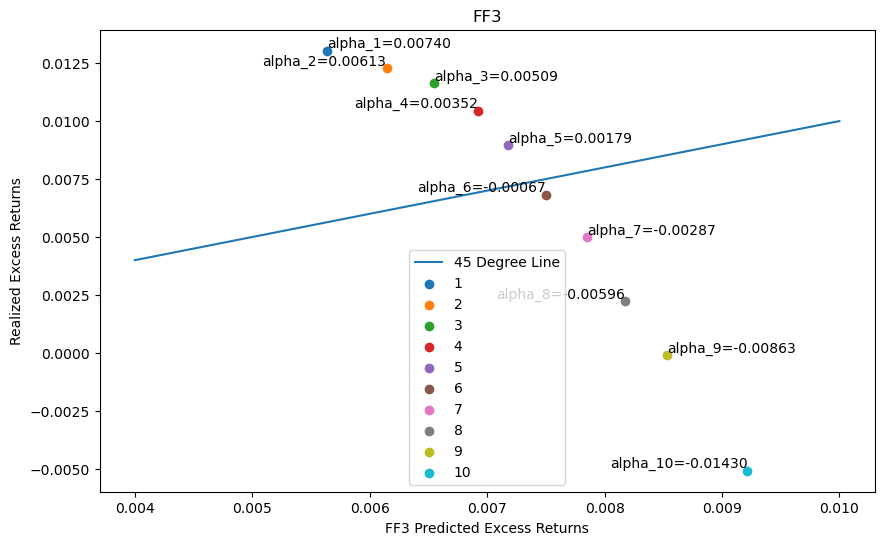

In [256]:
plt.figure(figsize=(10, 6))
# Plot the 45 degree line.
x = np.linspace(0.004, 0.01, 100)
plt.plot(x, x, label="45 Degree Line")
# Get the average factor/portfolio returns.
mkt_rets = sliced_ff3_df["Mkt-RF"].mean()
smb_rets = sliced_ff3_df["SMB"].mean()
hml_rets = sliced_ff3_df["HML"].mean()
for port in range(1, 11):
    # Get the portfolio alpha from the multivariate regression.
    alpha = port_ff3_df[str(port)]["Alpha"]
    # Get the betas/loadings from the regression.
    beta_m = port_ff3_df[str(port)]["Market Beta"]
    beta_smb = port_ff3_df[str(port)]["SMB Beta"]
    beta_hml = port_ff3_df[str(port)]["HML Beta"]
    # Use FF3 to get the model "predicted" returns.
    ff3_pred_rets = beta_m * mkt_rets + beta_smb * smb_rets + beta_hml * hml_rets
    # Get the historical realized average excess returns per month.
    realized_rets = excess_port_rets_df[str(port)].mean()
    # Plot the point and label the alphas.
    plt.scatter(ff3_pred_rets, realized_rets, label=str(port))
    h = 'left' if port % 2 else 'right'
    plt.text(ff3_pred_rets, realized_rets, f"alpha_{str(port)}={alpha:.5f}", va='bottom', ha=h)

plt.legend()
plt.xlabel("FF3 Predicted Excess Returns")
plt.ylabel("Realized Excess Returns")
plt.title("FF3")
plt.show()

# 2.4d. Discussing the Results

Even with the the Fama French 3 Factor Model, which has more statistically explanatory power than the CAPM, the FF3 model still cannot the puzzle. While FF3 allows for alphas to exist, the other aforementioned anamoly still exists. Recall that larger the EDF portfolio index, the higher the risk of the portfolio, yet as shown in the graph, portfolios with higher risk do not obtain higher returns. In fact, there's a clear relationship that shows that portfolios with higher risk here earn lower expected excess returns.